**Created on 15/12/2022**

**Authors: Amir Najjar, Sibel Yuksel**

**License: this notebook is released under the CeCILL 2.1 license. See https://www.cecill.info/licenses/Licence_CeCILL_V2.1-en.txt**

# Dataset 3 creation

Parts of this code are adapted from `CIR_high_resolution.py` created by Quentin Vey.

## Installations and Imports

It is recommended to install `ndjson` to work with the Newline Delimited JSON files provided by LocURa4IoT. More about `ndjson` [here](http://ndjson.org/) and [here](https://pypi.org/project/ndjson/).

In [1]:
!pip install ndjson

We import the required libraries and set the seaborn theme to `darkgrid` as specified in the quality cheat sheet. We also specify the directory where the data is located:

In [2]:
import ndjson
import json
import os
import base64
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
import warnings
sns.set_style('darkgrid')

In [3]:
def create_folder(directory: str) -> None:
    """
    Create a folder using a directory

    Parameters: 
        directory: directory of the folder to create
    """
    if not os.path.isdir(directory):
        os.makedirs(directory)

create_folder("./Datasets")
create_folder("./Datasets/Dataset_3")

In [4]:
DATA_LOC_CIR = './Data/CIR_dataset/'
EXPORT_LOC = './Datasets/'

Define helper functions:

In [5]:
def corrected_RXP_acc(RXPACC, RXPACC_NOSAT, DWSFD, RNSSFD, RXM110K, SFD_LENGTH) :
    """
    Function to compute a normalization factor, taken from manufacturer's  
    instructions
    Returns preamble accumulation count. See DW1000 user manual for 
    details, in the description of field RXPACC.
    """
    if RXPACC != RXPACC_NOSAT :   # easy case, no adjustment required
        return RXPACC
    else :
        if DWSFD == 0 and RNSSFD == 1:
            raise ValueError("Not implemented yet.")
        elif RNSSFD == 0 :
            if RXM110K == 1 :  
                return RXPACC - 64
            else :                  
                return RXPACC - 5
        else :
            if RXM110K == 1 :  
                return RXPACC - 82
            else :                  
                if SFD_LENGTH == 8 :
                    return RXPACC - 10
                elif SFD_LENGTH == 16 :
                    return RXPACC - 18
                else :
                    raise ValueError("Invalid SFD_LENGTH for this config")
                    
def make_normalized_CIR(ACC_MEM, first_index_raw, first_path_index, norm_factor) :
    """Function to decode CIR raw data"""
    # convert first_path_index (hardware-measured arrival date) in few useful 
    # values
    FP_integer = int(first_path_index // 64) - first_index_raw  # index in ACC_MEM
    FP_fractional = first_path_index % 64                   # fractional value
    FP_ns = first_path_index / 64                        # float value in ns
    # Note : in the dataset, the first firstIndexRaw values of the physical 
    # register are not recorded because it is just noise, hence the offset in
    # FP_integer above.
    # Note 2 : the first path index is given with a time resolution smaller than
    # the time sampling of ACC_MEM. That's why we split it in an integer part 
    # (that can be used to index ACC_MEM) and a fractional part (that can be 
    # used when finer resolution is needed). The fractional part is 6 bits long,
    # hence the 2**6=64 in the above computations.
    
    

    # convert the raw CIR sample data    
    # ACC_MEM is a base-64 encoded string containing ACC_MEM registry value : 
    # 32 bits complex samples (16bits for real and imaginary parts, big-endian)
    raw_bytes = base64.b64decode(ACC_MEM)
    Y = []
    for i in range(0, len(raw_bytes), 4):
        r = int.from_bytes(raw_bytes[i:i + 2], "big", signed=True)
        i = int.from_bytes(raw_bytes[i + 2:i + 4], "big", signed=True)
        Y.append(r + 1j * i)
    Y = np.array(Y, complex)
    
    # normalize the samples
    Y = Y / norm_factor
    
    # Note : the phase of the radio signal (argument of the complex value) is 
    # random, however its variations after the reception form a pattern that can
    # be studied like the amplitude of the radio signal (modulus of the complex 
    # number). In order to be able to compare each individual CIR in the complex
    # space, we arbitrarily set the phase to 0 at the first path index.
    
    # perform linear interpolation of the signal at arrival date (using 
    # fractional part of the first path index for better resolution)
    arrival_val = (Y[FP_integer] * (64-FP_fractional) \
                  + Y[FP_integer + 1] * FP_fractional) / 64
    arrival_phase = np.angle(arrival_val)
    
    # shift the phase for the whole record so that it is 0 at arrival date 
    Y = Y * np.exp(-1j * arrival_phase)
    
    # create an array to store the time index and fill it with time (in 
    # nanosecond) centered on hardware-measured arrival date
    X = np.array(range(first_index_raw, len(Y) + first_index_raw))
    X = [ x - FP_ns  for x in X ]
    X = np.array(X)
    
    return X, Y

def generate_hd_CIR(CIR_list):
    ### Compute the average, high-resolution curve
    ## Generate a high-def X vector
    min_X = min([e[0][0] for e in CIR_list])
    max_X = max([e[0][-1] for e in CIR_list])
    X_hd = np.arange(min_X, max_X + 1 / 64, 1 / 64)

    ## Generate "empty" arrays to store the intermediate computations values
    Y_hd_sum = np.ma.masked_invalid(np.full(X_hd.shape, np.nan))
    Y_hd_count = np.ma.masked_invalid(np.full(X_hd.shape, 0))
    
    ## go over the whole CIR set
    for e in CIR_list :
        X = e[0]
        Y = e[1]

        # compute index of first sample and how many values to add at the end
        first_index = int((e[0][0] - min_X) * 64)
    
        # expand Y list and fill it with nan to give it the same resolution 
        # as Y_hd_count
        Y = Y.reshape((Y.shape[0], 1))
        Y_hd = np.pad(Y, ((0, 0), (0, 63)), 'constant', constant_values=np.nan)
        Y_hd = Y_hd.reshape((Y.shape[0] * 64,))[:-63]
        # pad Y_hd to give it the same size as the final arrays
        missing_values = Y_hd_count.shape[0] - (first_index + Y_hd.shape[0])
        Y_hd = np.pad(Y_hd,
                    (first_index, missing_values), 
                    'constant', 
                    constant_values=np.nan)
        Y_hd = np.ma.masked_invalid(Y_hd)
    
        # adds it to the aggregated arrays
        Y_hd_sum = np.ma.sum(np.ma.array((Y_hd_sum, Y_hd)), axis = 0)
        Y_hd_count = np.ma.sum( 
                     np.ma.array(
                       (Y_hd_count, np.ma.masked_invalid(np.where(Y_hd.mask, np.nan, 1)))
                     ), 
                     axis = 0)

    ## compute the average
    Y_hd_avg = Y_hd_sum / Y_hd_count

    return X_hd, Y_hd_avg

def generate_CIR_list_df(CIR_list, src, dest):
    min_X = min([e[0][0] for e in CIR_list])
    columns_list = ['source', 'dest', 't0'] + [f'modulus_comp_{str(i).zfill(2)}' for i in range(100)] + \
                    [f'modulus_abs_{str(i).zfill(2)}' for i in range(100)]
    row_list = []
    for cir in CIR_list:
        row = [src, dest, cir[0][0]] + list(cir[1]) + list(abs(cir[1]))
        row_list.append(row)
    df = pd.DataFrame(row_list, columns=columns_list)
    return df

Create Dataset 3:

In [6]:
for filename in os.listdir(DATA_LOC_CIR):
    f = os.path.join(DATA_LOC_CIR, filename)
    # Skip if the file is not a json
    if not os.path.isfile(f):
        continue
    if f[-4:] != 'json':
        continue
    # Show progress
    print(f'Processing file {filename}       ', end='\r')
    # Load the data into a DataFrame
    data = ndjson.loads(open(f, 'r').read())
    df = pd.DataFrame(data)
    # Sort by node_id and timestamp
    df.sort_values(by=['node_id', 'timestamp'], inplace=True)
    # Define the source node and the destination node
    dest_node = df.iloc[0].node_id
    src_node = df.iloc[-1].node_id
    prev_node = df.iloc[0].node_id
    CIR_list = []
    for idx, row in df.iterrows():
        # If source and destination switched
        if row.node_id != prev_node:
            # Save HD CIR
            X_hd, Y_hd = generate_hd_CIR(CIR_list)
            CIR_df = pd.DataFrame()
            CIR_df['source'] = [src_node] * len(Y_hd)
            CIR_df['dest'] = dest_node
            CIR_df['time_hd'] = X_hd
            CIR_df['modulus_hd_comp'] = Y_hd
            CIR_df['modulus_hd_abs'] = abs(Y_hd)
            CIR_df.dropna(inplace=True)
            CIR_df.to_csv(f'{EXPORT_LOC}/Dataset_3/CIR_HD_FROM_{src_node}_TO_{dest_node}.csv', index=False)
            # Save the split CIR that allow to recreate HD CIR
            CIR_split = generate_CIR_list_df(CIR_list, src_node, dest_node)
            CIR_split.to_csv(f'{EXPORT_LOC}/Dataset_3/CIR_SPLIT_FROM_{src_node}_TO_{dest_node}.csv', index=False)
            # Switch source and destination to treat the other half of the messages
            src_node = df.iloc[0].node_id
            dest_node = df.iloc[-1].node_id
            prev_node = row.node_id
            CIR_list = []
        dump = row.payload['registerDump_CIR']
        record_start = dump['ACC_MEM_first_index']
        record_end  = record_start + len(base64.b64decode(dump['ACC_MEM'])) / 4
        FP_index_integer = dump['FP_INDEX'] // 64 # floor division
        # test that the arrival index is within the recorded sample. Discard 
        # this record otherwise
        if  FP_index_integer < record_end-1 \
                and FP_index_integer > record_start:
            # Compute normalized CIR and store it in CIR_list
            normalizationFactor = corrected_RXP_acc(
                                            dump['RXPACC'],
                                            dump['RXPACC_NOSAT'],
                                            dump['DWSFD'],
                                            dump['RNSSFD'],
                                            dump['RXM110K'],
                                            dump['SFD_LENGTH'])
            X, Y = make_normalized_CIR(
                            dump['ACC_MEM'], 
                            dump['ACC_MEM_first_index'],
                            dump['FP_INDEX'],
                            normalizationFactor
                            )
            CIR_list.append((X, Y))
    X_hd, Y_hd = generate_hd_CIR(CIR_list)
    # Save the other part
    CIR_df = pd.DataFrame()
    CIR_df['source'] = [src_node] * len(Y_hd)
    CIR_df['dest'] = dest_node
    CIR_df['time_hd'] = X_hd
    CIR_df['modulus_hd_comp'] = Y_hd
    CIR_df['modulus_hd_abs'] = abs(Y_hd)
    CIR_df.dropna(inplace=True)
    CIR_df.to_csv(f'{EXPORT_LOC}/Dataset_3/CIR_HD_FROM_{src_node}_TO_{dest_node}.csv', index=False)
    CIR_split = generate_CIR_list_df(CIR_list, src_node, dest_node)
    CIR_split.to_csv(f'{EXPORT_LOC}/Dataset_3/CIR_SPLIT_FROM_{src_node}_TO_{dest_node}.csv', index=False)

## Dataset 3 examples

In [7]:
def formatter(x, pos):
    """formatter for ticks labels"""
    return '{} ns\n{} m'.format(
                '{:6f}'.format(x).rstrip('0'),
                '{:6f}'.format(x*0.3).rstrip('0')
                )

In [8]:
df_test = pd.read_csv(f'{EXPORT_LOC}/Dataset_3/CIR_SPLIT_FROM_106_TO_100.csv')
df_hd = pd.read_csv(f'{EXPORT_LOC}/Dataset_3/CIR_HD_FROM_106_TO_100.csv')
for i in range(100):
    col_name = f'modulus_comp_{str(i).zfill(2)}'
    df_test[col_name] = df_test[col_name].astype(complex)
df_hd.modulus_hd_comp = df_hd.modulus_hd_comp.astype(complex)

In [9]:
## select 5 individual CIR to compare with the average
random_indices = random.sample(range(len(df_test)), 5)
warnings.filterwarnings('ignore')

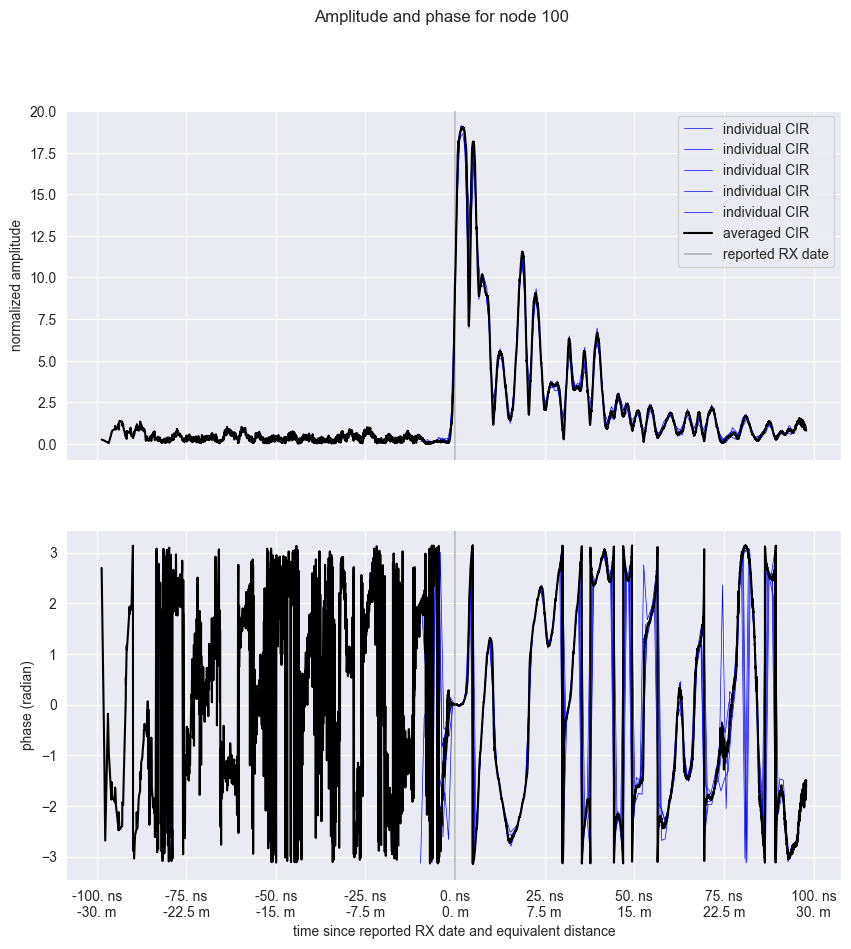

In [10]:
## First plot: amplitude and phase for the average and 10 randomly selected CIR
fig, (ax, ax_phase) = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
for idx in random_indices :
    row = df_test.iloc[idx]
    X = np.array([row.t0 + i for i in range(100)])
    columns_comp = [f'modulus_comp_{str(i).zfill(2)}' for i in range(100)]
    columns_abs = [f'modulus_abs_{str(i).zfill(2)}' for i in range(100)]
    Y_comp = np.array([row[columns_comp]], complex).reshape(-1, 1)
    Y_abs = np.array([row[columns_abs]]).reshape(-1, 1)
    # amplitude plot
    ax.plot(
        X,
        Y_abs,
        c='b',
        linewidth=0.5, label='individual CIR'
    )
    # phase plot
    ax_phase.plot(
        X,
        np.angle(Y_comp),
        c='b', 
        linewidth=0.5, label='individual CIR'
    )
# amplitude plot
ax.plot(df_hd.time_hd, df_hd.modulus_hd_abs, c='k', label='averaged CIR')
# phase plot
ax_phase.plot(df_hd.time_hd, np.angle(df_hd.modulus_hd_comp), c='k', label='averaged CIR')
# titles, etc.
fig.suptitle("Amplitude and phase for node 100")
ax.set_ylabel("normalized amplitude")
ax_phase.set_ylabel("phase (radian)")
ax_phase.set_xlabel("time since reported RX date and equivalent distance")
ax.axvline(0, color='k', linewidth=0.3, label="reported RX date")
ax_phase.axvline(0, color='k', linewidth=0.3, label="reported RX date")
ax_phase.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.legend()

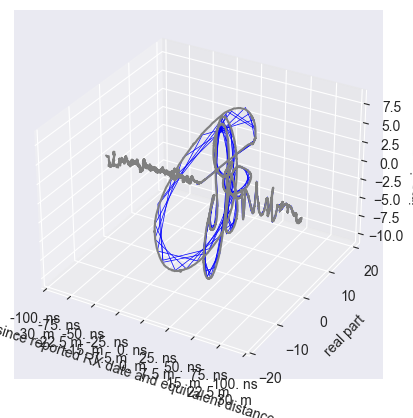

In [11]:
fig3d = plt.figure()
ax3d = plt.axes(projection='3d')

for idx in random_indices :
    row = df_test.iloc[idx]
    X = np.array([row.t0 + i for i in range(100)])
    columns_comp = [f'modulus_comp_{str(i).zfill(2)}' for i in range(100)]
    columns_abs = [f'modulus_abs_{str(i).zfill(2)}' for i in range(100)]
    Y_comp = np.array([row[columns_comp]], complex).reshape(-1, 1).flatten()
    ax3d.plot3D(np.ma.array(X),
                np.real(Y_comp),
                np.imag(Y_comp),
                c='b', 
                linewidth=0.5)
    
ax3d.plot3D(df_hd.time_hd, np.real(df_hd.modulus_hd_comp), np.imag(df_hd.modulus_hd_comp), 'gray')
ax3d.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax3d.set_xlabel("time since reported RX date and equivalent distance")
ax3d.set_ylabel("real part")
ax3d.set_zlabel("imaginary part")
ax3d.set_xlim(-100,100)
plt.title('')
plt.show()

Construct HD CIR from the split CIRs:

In [12]:
CIR_list = []
for idx, row in df_test.iterrows():
    X = np.array([row.t0 + i for i in range(100)], float)
    columns_comp = [f'modulus_comp_{str(i).zfill(2)}' for i in range(100)]
    Y = np.array(row[columns_comp]).reshape(1, -1).flatten()
    CIR_list.append((X, Y))
X_hd_const, Y_hd_const = generate_hd_CIR(CIR_list)

Plot constructed CIR:

Text(0.5, 1.0, 'Construted HD CIR')

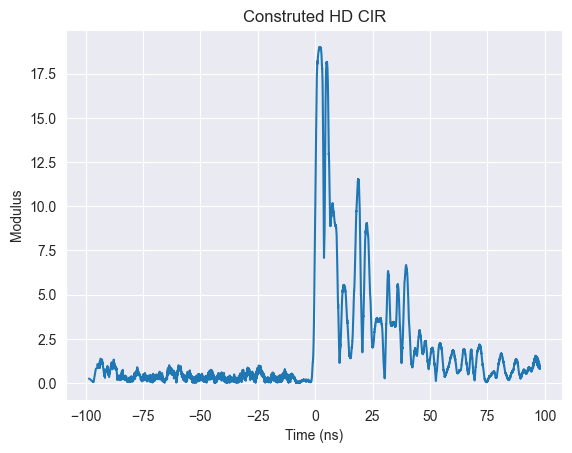

In [13]:
plt.plot(df_hd.time_hd, abs(Y_hd_const[Y_hd_const.mask == False]))
plt.xlabel('Time (ns)')
plt.ylabel('Modulus')
plt.title('Construted HD CIR')

Plot CIR from DataFrame:

Text(0.5, 1.0, 'HD CIR From DataFrame')

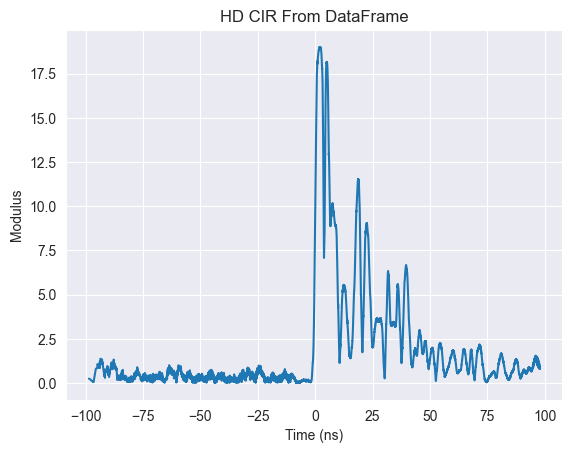

In [14]:
plt.plot(df_hd.time_hd, df_hd.modulus_hd_abs)
plt.xlabel('Time (ns)')
plt.ylabel('Modulus')
plt.title('HD CIR From DataFrame')